# Importation des dépendances#


In [1]:
import numpy as np
import pandas as pd
import cv2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
import os

# Definition des variables globales du fichier

In [2]:
image_size = 32

dir_base = '../xray'

test_normal = '/'.join([dir_base, 'test', 'NORMAL'])
test_pneumonia = '/'.join([dir_base, 'test', 'PNEUMONIA'])

train_normal = '/'.join([dir_base, 'train', 'NORMAL'])
train_pneumonia = '/'.join([dir_base, 'train', 'PNEUMONIA'])

length_data = {
    "train": 0,
    "test": 0
}

# fonction du fichier

- permet de calculer la longueur d'un dataset

In [3]:
def get_length_data(normal_dir, pneumonia_dir):
    return min(len(os.listdir(normal_dir)), len(os.listdir(pneumonia_dir)))

- permet d'importer un dataset

In [4]:
def get_data(path, label, data_type, training=False):
    result = []
    dir_files = os.listdir(path)
    if training:
        dir_files = dir_files[:length_data[data_type]]
    for nameImg in dir_files:
        if nameImg != '.DS_Store':
            img_path = '/'.join([dir_base, data_type, label, nameImg])
            #print(img_path)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA).reshape(1, -1)
            result.append((img, label))
    return pd.DataFrame(result, columns=['image', 'label'], index=None)

- affiche le graph pour choisir le meilleur k

In [5]:
def graph_accuracy_by_k(k_values, accuracy_values):
    fig = plt.figure()
    fig.subplots_adjust(top=0.8)
    ax1 = fig.add_subplot()
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('K value')
    plt.plot(k_values,accuracy_values,label='Accuracy for k params')
    plt.scatter(k_values,accuracy_values,c=k_values,alpha=1)
    plt.legend()
    plt.show()

- affiche la matrice de confusion

In [6]:
def graph_confusion_matrix(model, x, y):
    disp = plot_confusion_matrix(model, x, y, cmap=plt.cm.Blues, normalize=None)
    plt.show()


# recherche du meilleur k voisins pour notre dataset

Dans cette partie on recherche le meilleur k (nombre de voisin) pour l'algorythme.
Pour ce faire on oublie pas d'égaliser les dataset "NORMAL" et "PNEUMONIE" pour ne pas biasier l'entrainement.
On test sur 85% du dataset training et on test sur les 15% restant.

Accuracy for k=1: 0.9255583126550868


              precision    recall  f1-score   support

      NORMAL       0.94      0.91      0.93       205
   PNEUMONIA       0.91      0.94      0.93       198

    accuracy                           0.93       403
   macro avg       0.93      0.93      0.93       403
weighted avg       0.93      0.93      0.93       403



Accuracy for k=3: 0.9354838709677419


              precision    recall  f1-score   support

      NORMAL       0.95      0.92      0.94       205
   PNEUMONIA       0.92      0.95      0.94       198

    accuracy                           0.94       403
   macro avg       0.94      0.94      0.94       403
weighted avg       0.94      0.94      0.94       403



Accuracy for k=5: 0.9354838709677419


              precision    recall  f1-score   support

      NORMAL       0.95      0.92      0.94       205
   PNEUMONIA       0.92      0.95      0.94       198

    accuracy                           0.94       403
   macr

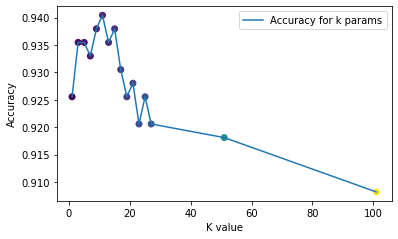

In [7]:
length_data["train"] = get_length_data(train_normal, train_pneumonia)
length_data["test"] = get_length_data(test_normal, test_pneumonia)

data = pd.concat([get_data(train_normal, 'NORMAL', 'train', True), get_data(train_pneumonia, 'PNEUMONIA', 'train', True)])

y = data.label

X = []
for i in data.image.values:
    X.append(i[0])
X = np.array(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=30)


k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 51, 101]
accuracy_values = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, predictions)
    accuracy_values.append(acc)
    print('Accuracy for k={}:'.format(str(k)), acc)
    print('\n')
    print(classification_report(y_test, predictions))
    print('====================================================')
    print('\n')

graph_accuracy_by_k(k_values, accuracy_values)

on peut voir que le k=17 et le k=23 ont la meilleur accuracy, dans notre cas on va partir avec k = 23

# On entraine le modèle sur l'entièreté du dataset training et on effectue la prediction sur le dataset test

In [8]:
knn_model = KNeighborsClassifier(n_neighbors=23)
knn_model.fit(X, y)

test_data_total = pd.concat([get_data(test_normal, 'NORMAL', 'test'), get_data(test_pneumonia, 'PNEUMONIA', 'test')])

y_label = test_data_total.label

X_test_data = []
for i in test_data_total.image.values:
    X_test_data.append(i[0])

X_test_data = np.array(X_test_data)

y_pred = knn_model.predict(X_test_data)

metriques d'accuracy et matrice de confusion

Accuracy for test 0.8365384615384616
              precision    recall  f1-score   support

      NORMAL       0.85      0.68      0.76       234
   PNEUMONIA       0.83      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624



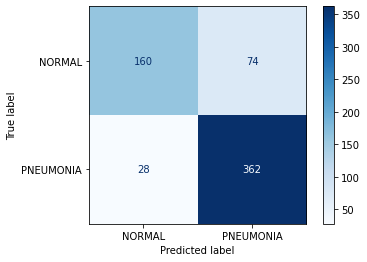

In [9]:
acc_test = metrics.accuracy_score(y_label, y_pred)
print('Accuracy for test', acc_test)
print(classification_report(y_label, y_pred))

graph_confusion_matrix(knn_model, X_test_data, y_label)

metriques roc et loss

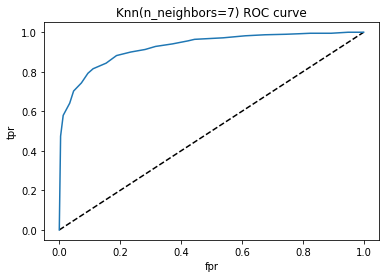

0.92583278544817
0.39664432459347804


In [10]:
y_pred_proba = knn_model.predict_proba(X_test_data)[:, 1]


fpr, tpr, thresholds = roc_curve(y_label, y_pred_proba, pos_label="PNEUMONIA")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=7) ROC curve')
plt.show()

roc = roc_auc_score(y_label, y_pred_proba)
print(roc)
print(log_loss(y_label, y_pred_proba))